# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: 

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

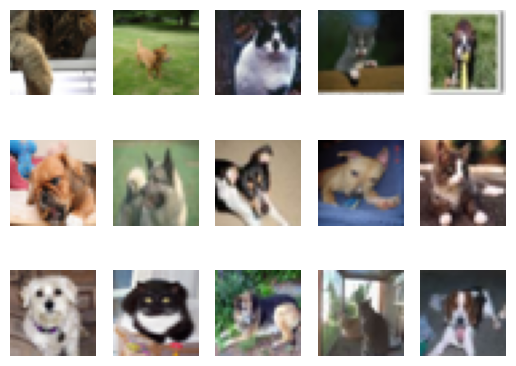

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [5]:
print("Train: ", len(train_loader))
print("Val: ", len(val_loader))
print("Test: ", len(test_loader))

Train:  8000
Val:  2000
Test:  2000


**Answer**: We have 8000 training images, 2000 validation images, and 2000 test images. Each image is either a cat or a dog.

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

**Answer**:
We need a validation set when training our model because we want to be able to evaluate our model on data that it has not seen before. 
This is important because we want to be able to see how well our model generalizes to new data. 
If we did not have a validation set, we would not be able to evaluate our model on new data. 
We would only be able to evaluate our model on the training data, the model will be biased towards the training data. 
As a result, the model would be more likely to overfit to the training data, and would not perform well on new data.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [6]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [9]:
small_net_params = 0
large_net_params = 0
for params in small_net.parameters():
    small_net_params += params.numel()
for params in large_net.parameters():
    large_net_params += params.numel()
print("Small net has {} parameters".format(small_net_params))
print("Large net has {} parameters".format(large_net_params))

Small net has 386 parameters
Large net has 9705 parameters


**Answer** small_net has 386 parameters. Large net has 9705 parameters

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [10]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

**Answer**: default batch_size=64, default learning_rate=0.01, default num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

**Answer**: Using the small_net, and training for 5 epoch, we use the default batch_size=64, default learning_rate=0.01. Therefore the model_path will be `model_small_bs64_lr0.01_epoch5`
These following files will be written to disk
1. `model_small_bs64_lr0.01_epoch5_train_err.csv`: training error per epoch, calculated by number of incorrectly labelled output over number of training labels
2. `model_small_bs64_lr0.01_epoch5_train_loss.csv`: training loss per epoch
3. `model_small_bs64_lr0.01_epoch5_val_err.csv`: validation error per epoch
4. `model_small_bs64_lr0.01_epoch5_val_loss.csv`: validation loss per epoch
5. `model_small_bs64_lr0.01_epoch5_epoch0`: saved model checkpoint for first epoch
6. `model_small_bs64_lr0.01_epoch5_epoch1`: saved model checkpoint for second epoch
7. `model_small_bs64_lr0.01_epoch5_epoch2`: saved model checkpoint for third epoch
8. `model_small_bs64_lr0.01_epoch5_epoch3`: saved model checkpoint for forth epoch
9. `model_small_bs64_lr0.01_epoch5_epoch4`: saved model checkpoint for fifth epoch

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [11]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

# from google.colab import drive;
# drive.mount('/content/gdrive');

In [14]:
# using default parameters to train
small_net = SmallNet()
large_net = LargeNet()
print("SmallNet")
train_net(small_net)
print("LargeNet")
train_net(large_net)

SmallNet
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.434875, Train loss: 0.678674180984497 |Validation err: 0.382, Validation loss: 0.6585669107735157
Epoch 2: Train err: 0.365875, Train loss: 0.6462580580711365 |Validation err: 0.3755, Validation loss: 0.6533174924552441
Epoch 3: Train err: 0.349125, Train loss: 0.6314852027893066 |Validation err: 0.3505, Validation loss: 0.628373896703124
Epoch 4: Train err: 0.336625, Train loss: 0.6171161842346191 |Validation err: 0.3715, Validation loss: 0.6352456733584404
Epoch 5: Train err: 0.325625, Train loss: 0.6068310470581054 |Validation err: 0.336, Validation loss: 0.6212833765894175
Epoch 6: Train err: 0.31975, Train loss: 0.5978274965286254 |Validation err: 0.347, Validation loss: 0.6205896716564894
Epoch 7: Train err: 0.31225, Train loss: 0.5929948098659515 |Validation err: 0.33, Validation loss: 0.6081493385136127
Epoch 8: Train err: 0.30825, Train loss: 0.5860757207870484 |Validatio

**Answer**: `small_net` takes 111.60 seconds to train. `large_net` takes 111.76 seconds. Both took around the same time to train, though larget_net took slightly longer to train. The reason is because that larget_net has more parameters to train. 

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

small_net: 


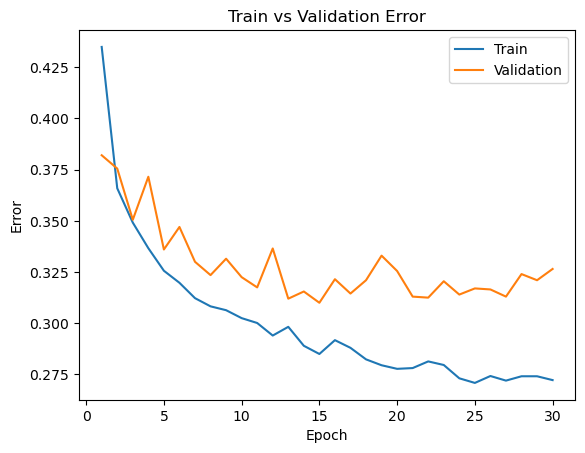

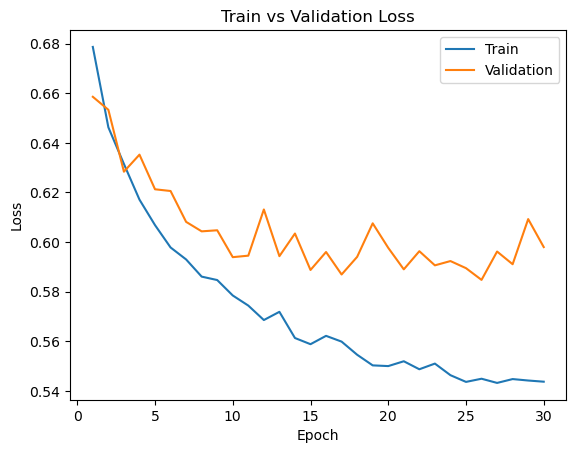

In [17]:
print("small_net: ")
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

large_net: 


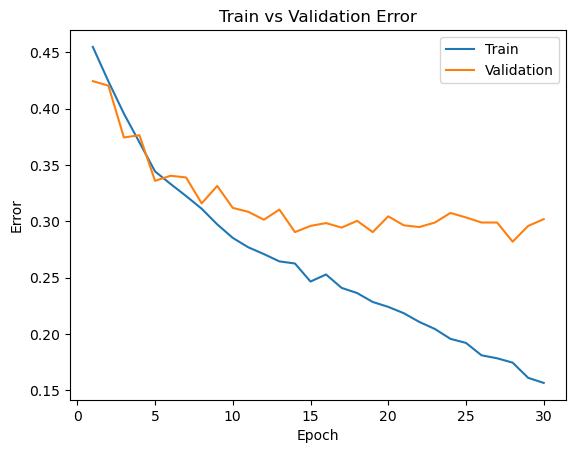

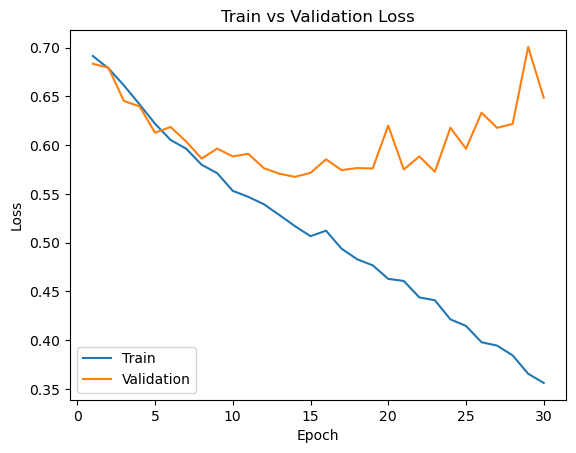

In [18]:
print("large_net: ")
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**Answer**:
The training curve for both nets decrease's over epoch. Generally it decreases fast initially, then slows down.
Differences:
- `small_net`'s training error decreased more rapidly compared to `large_net` initially, creating a steeper descent
- `small_net`'s training loss is a concave curve, where as `large_net`'s is almost linear
- `small_net` has more noise (bumps) compared to `large_net`

`larget_net` is overfit, as the validation loss flattens at around epoch 10-15, and starts increasing after epoch 15 even though training loss is decreasing. 

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.692258972644806 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067366600036 |Validation err: 0.4285, Validation loss: 0.6908544525504112
Epoch 4: Train err: 0.43, Train loss: 0.6908613343238831 |Validation err: 0.424, Validation loss: 0.689659645780921
Epoch 5: Train err: 0.434375, Train loss: 0.6899195456504822 |Validation err: 0.4195, Validation loss: 0.6886939387768507
Epoch 6: Train err: 0.435625, Train loss: 0.6887412276268006 |Validation err: 0.4195, Validation loss: 0.686782531440258
Epoch 7: Train err: 0.437, Train loss: 0.6873769574165344 |Validation err: 0.4185, Validation loss: 0.6851976979523897
Epoch 8: Train err: 0.4375, Train loss: 0.685926775932312 |Validation err: 0.412, Val

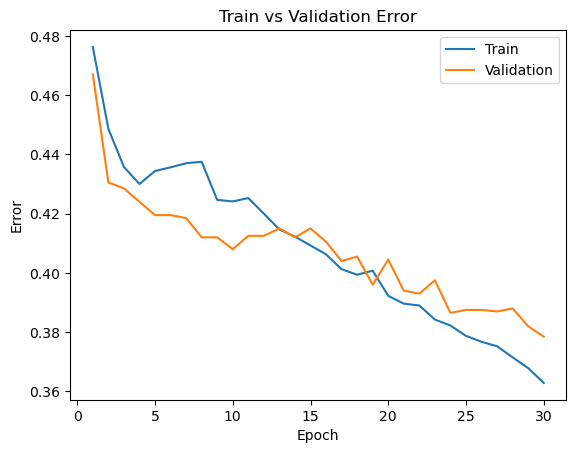

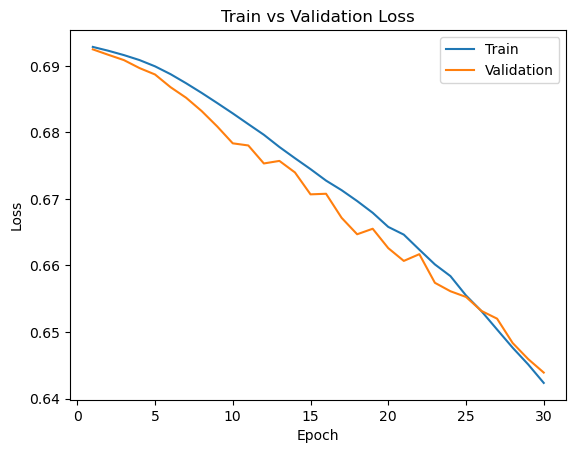

In [19]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

**Answer**:

The model took around same time to train as compared to before. Lowering the learning rate lowers training speed, which results in lower loss / accuracy changes per epoch. It is also interesting to note that this model seems to be underfitted, as the training and validation loss is still decreasing at the end, and could use some more epoch before reaching an optimal point for this model.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.429875, Train loss: 0.6752145810127258 |Validation err: 0.378, Validation loss: 0.6376268099993467
Epoch 2: Train err: 0.354, Train loss: 0.6315004854202271 |Validation err: 0.369, Validation loss: 0.6321007180958986
Epoch 3: Train err: 0.3715, Train loss: 0.6381572265625 |Validation err: 0.3515, Validation loss: 0.6171668563038111
Epoch 4: Train err: 0.331125, Train loss: 0.6085624132156372 |Validation err: 0.322, Validation loss: 0.5960786482319236
Epoch 5: Train err: 0.330875, Train loss: 0.6013813314437866 |Validation err: 0.3335, Validation loss: 0.6044734138995409
Epoch 6: Train err: 0.313125, Train loss: 0.5833973135948182 |Validation err: 0.3195, Validation loss: 0.6670912457630038
Epoch 7: Train err: 0.310875, Train loss: 0.5805643837451935 |Validation err: 0.3375, Validation loss: 0.6255019539967179
Epoch 8: Train err: 0.298, Train loss: 0.5633381624221802 |Validation err: 0.345,

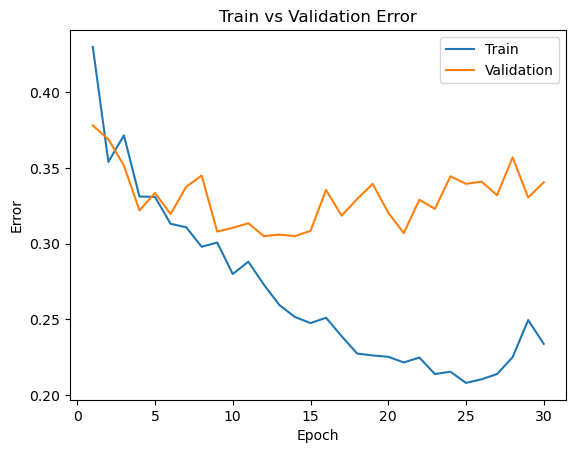

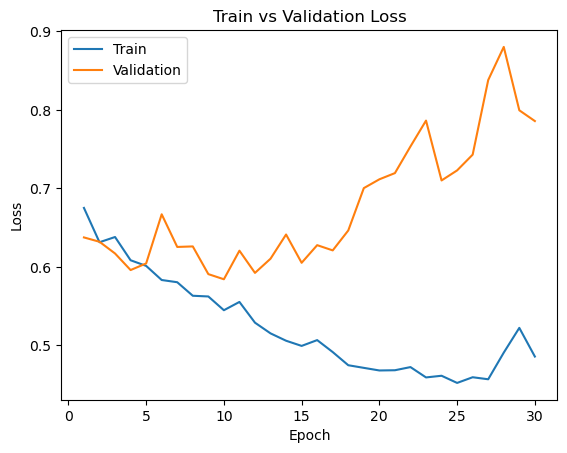

In [20]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

**Answer**:

Model took around the same amount of time to train (`110.47` sec). Increasing the learning rate from `0.01` to `0.1` increased the magnitude of the gradient descent step per epoch. The error / loss graph (at least for training) decreased faster compared to default settings, and as a result the model started to overfit eariler compared to the default model. 

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379478096962 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103982746601 |Validation err: 0.434, Validation loss: 0.6917425394058228
Epoch 3: Train err: 0.437, Train loss: 0.6916500367224216 |Validation err: 0.4265, Validation loss: 0.6909129768610001
Epoch 4: Train err: 0.433625, Train loss: 0.690845001488924 |Validation err: 0.424, Validation loss: 0.6897871047258377
Epoch 5: Train err: 0.434, Train loss: 0.6896936409175396 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534118533134 |Validation err: 0.428, Validation loss: 0.6860129982233047
Epoch 7: Train err: 0.439375, Train loss: 0.6866870187222958 |Validation err: 0.426, Validation loss: 0.6836968511343002
Epoch 8: Train err: 0.435375, Train loss: 0.6849770322442055 |Validation err: 0.412, 

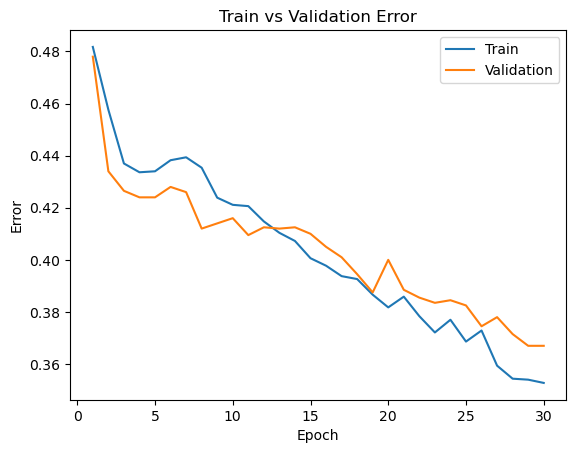

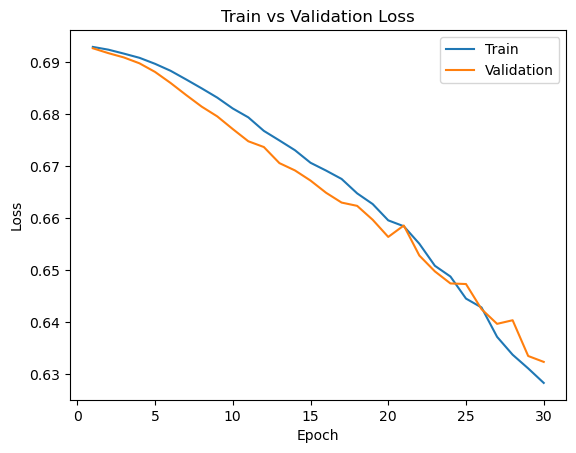

In [21]:
large_net = LargeNet()
train_net(large_net, batch_size=512)
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

**Answer**

Training took around the same time as previous models (`111.03` seconds). Increasing the batch size from `64` to `512`, the model's loss decreases slower. As a result, the model is no longer overfitted, but rather underfitted since the loss is still decreasing at the end of training, and the error rate is higher compared to default model.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.431625, Train loss: 0.6774841866493225 |Validation err: 0.38, Validation loss: 0.6513742227554321
Epoch 2: Train err: 0.367875, Train loss: 0.6394536781311035 |Validation err: 0.362, Validation loss: 0.6258115847110748
Epoch 3: Train err: 0.344, Train loss: 0.6121539530158043 |Validation err: 0.341, Validation loss: 0.6298514568805694
Epoch 4: Train err: 0.31375, Train loss: 0.5840702010989189 |Validation err: 0.3575, Validation loss: 0.6196025292873383
Epoch 5: Train err: 0.305375, Train loss: 0.5662210270762443 |Validation err: 0.3105, Validation loss: 0.5783455855846406
Epoch 6: Train err: 0.286875, Train loss: 0.5464030002355575 |Validation err: 0.3075, Validation loss: 0.5893935015201569
Epoch 7: Train err: 0.274, Train loss: 0.5271157467961312 |Validation err: 0.3145, Validation loss: 0.5784460620880127
Epoch 8: Train err: 0.257, Train loss: 0.5062099587917328 |Validation err: 0.3245

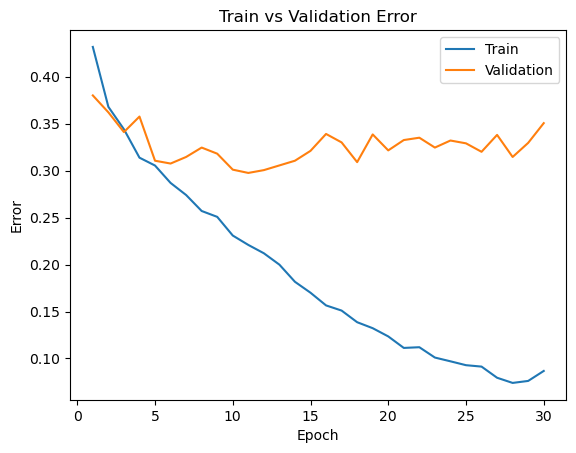

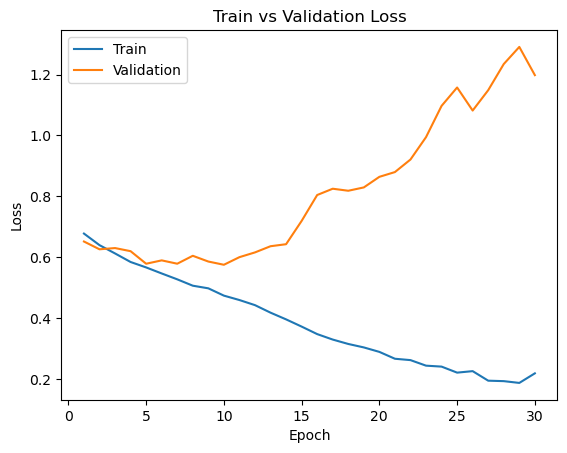

In [22]:
large_net = LargeNet()
train_net(large_net, learning_rate= 0.01, batch_size=16)
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

**Answer**

This model took slightly longer to train (`126.02` sec). Decreasing the batch size from `64` to `16` increased the rate of loss decrease. As a result the model quickly became overfitted. We can see that because the training loss / error is decreasing but the validation loss / error increases rapidly.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

**Answer**

Based on the plots from above, I pick `large_net`, `batch_size=256`, and `learning_rate= 0.05`.

`large_net` because it is less susceptible to noise. `batch_size=256` and `learning_rate= 0.05` because increasing batch size decreases learning gradient, while increasing learning rate increases training gradient, hopefully counteracting each other out and producing a model that is not underfitted nor overfitted.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44725, Train loss: 0.6909993384033442 |Validation err: 0.4235, Validation loss: 0.6842970252037048
Epoch 2: Train err: 0.424875, Train loss: 0.6800134014338255 |Validation err: 0.4215, Validation loss: 0.6766114309430122
Epoch 3: Train err: 0.399875, Train loss: 0.6665603257715702 |Validation err: 0.3785, Validation loss: 0.6534582376480103
Epoch 4: Train err: 0.373875, Train loss: 0.6450661439448595 |Validation err: 0.3905, Validation loss: 0.6552042216062546
Epoch 5: Train err: 0.353, Train loss: 0.6330915242433548 |Validation err: 0.35, Validation loss: 0.6281284689903259
Epoch 6: Train err: 0.337875, Train loss: 0.609631946310401 |Validation err: 0.338, Validation loss: 0.6276049762964249
Epoch 7: Train err: 0.34325, Train loss: 0.6170983090996742 |Validation err: 0.325, Validation loss: 0.6165948957204819
Epoch 8: Train err: 0.314625, Train loss: 0.5856548473238945 |Validation err: 0.

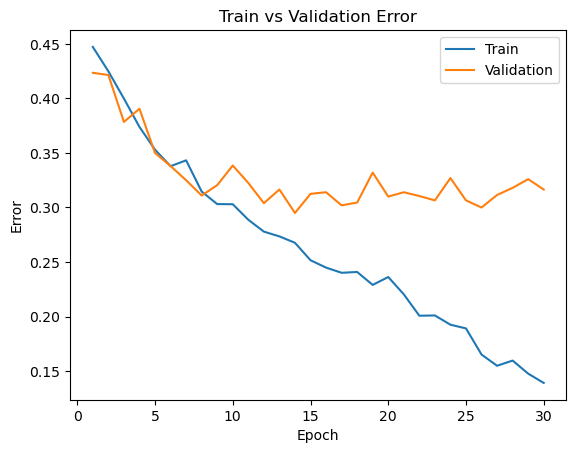

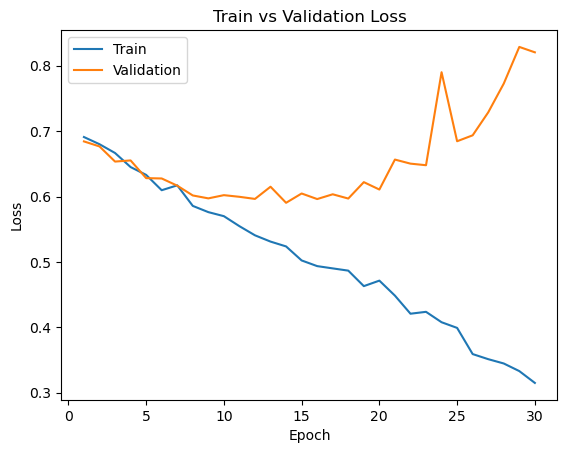

In [23]:
large_net = LargeNet()
train_net(large_net, learning_rate= 0.05, batch_size=256)
model_path = get_model_name("large", batch_size=256, learning_rate=0.05, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

**Answer**

The model above started overfitting at around epoch=10. To counter this, I'll decrease `learning rate` from `0.05` to `0.02`. This will slow down the training gradient which hopefully means the model won't overfit.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.455375, Train loss: 0.692277705296874 |Validation err: 0.426, Validation loss: 0.6905387863516808
Epoch 2: Train err: 0.448, Train loss: 0.6890578083693981 |Validation err: 0.4185, Validation loss: 0.68386210501194
Epoch 3: Train err: 0.427125, Train loss: 0.683222021907568 |Validation err: 0.4145, Validation loss: 0.6754546388983727
Epoch 4: Train err: 0.413375, Train loss: 0.6752700656652451 |Validation err: 0.408, Validation loss: 0.6675298437476158
Epoch 5: Train err: 0.40325, Train loss: 0.6690713856369257 |Validation err: 0.399, Validation loss: 0.6612358838319778
Epoch 6: Train err: 0.388, Train loss: 0.6608152482658625 |Validation err: 0.3855, Validation loss: 0.6552622616291046
Epoch 7: Train err: 0.37425, Train loss: 0.6502972040325403 |Validation err: 0.3775, Validation loss: 0.6456824764609337
Epoch 8: Train err: 0.36525, Train loss: 0.6388287805020809 |Validation err: 0.3685, 

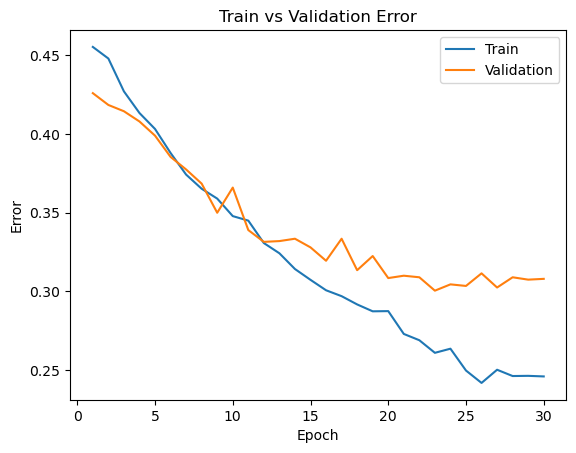

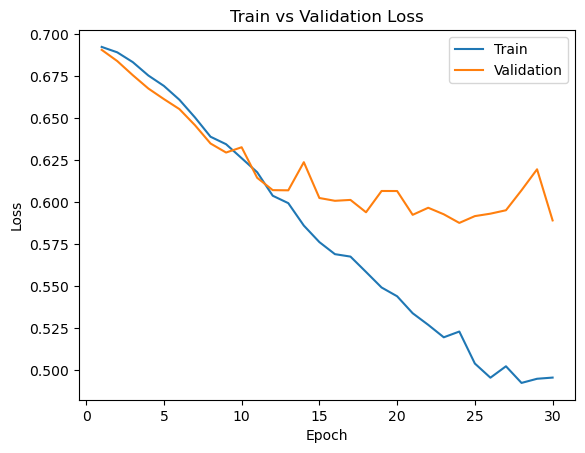

In [24]:
large_net = LargeNet()
train_net(large_net, learning_rate= 0.02, batch_size=256)
model_path = get_model_name("large", batch_size=256, learning_rate=0.02, epoch=29)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [26]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=256, learning_rate=0.02, epoch=23)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

**Answer**

I choose this model because it has the lowest validation loss (`0.3005`) out of all the other model checkpoints. The validation loss is also quite stable at this point, which indicates a fairly optimised model.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [28]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
_, _, test_loader, _ = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=256)
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print(f"Test classification error: {test_err}, Test loss: {test_loss}")

Files already downloaded and verified
Files already downloaded and verified
Test classification error: 0.3, Test loss: 0.5713841766119003


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

**Answer**

The test classification error is almost the same as the validation error (`0.3` vs `0.3005`). Even though for this test case the test classification error is lower than validation error, we generally expect the test error to be higher, because the model is exposed to new data for the first time, as compared to the validation dataset which was used seen multiple times while tuning the hyperparameters. 

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**Answer**

We only use the test data at the very end because it provides unbiased evaluation. By keeping test data separate during the training and validation phases, we can see how the model generalizes new unseen data. This provides a reliable and fair assessment of the model's true performance. 

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [32]:
# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self, num_hidden=30, activation_function=torch.relu):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.activation_function = activation_function
        self.layer1 = nn.Linear(32 * 32 * 3, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = self.activation_function(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.414125, Train loss: 0.6636841731071472 |Validation err: 0.393, Validation loss: 0.6507337652146816
Epoch 2: Train err: 0.373875, Train loss: 0.6383752117156982 |Validation err: 0.392, Validation loss: 0.6578669100999832
Epoch 3: Train err: 0.35625, Train loss: 0.6271215119361877 |Validation err: 0.3755, Validation loss: 0.6445923876017332
Epoch 4: Train err: 0.34275, Train loss: 0.6158278303146363 |Validation err: 0.397, Validation loss: 0.6674672290682793
Epoch 5: Train err: 0.327, Train loss: 0.6033829600811005 |Validation err: 0.3835, Validation loss: 0.6477418541908264
Epoch 6: Train err: 0.310375, Train loss: 0.5885210802555084 |Validation err: 0.3745, Validation loss: 0.6543322242796421
Epoch 7: Train err: 0.302625, Train loss: 0.5773693730831146 |Validation err: 0.3865, Validation loss: 0.6594871785491705
Epoch 8: Train err: 0.29025, Train loss: 0.5601858973503113 |Validation err: 0

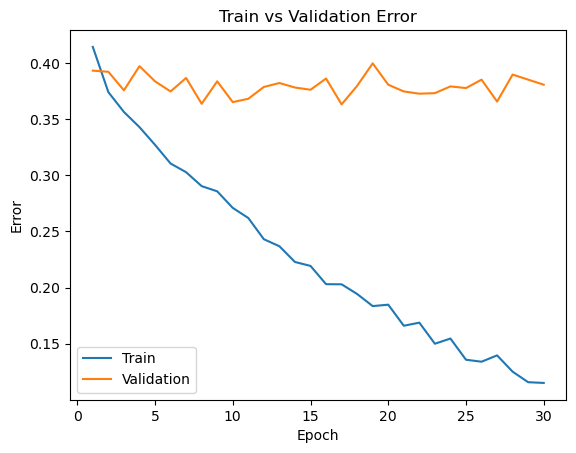

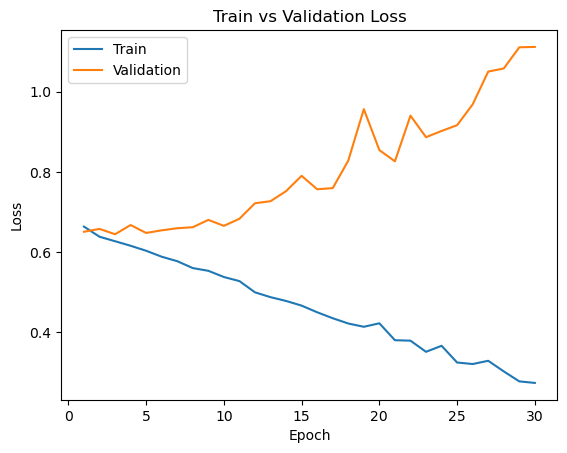

In [33]:
pigeon = Pigeon()
train_net(pigeon, batch_size=64, learning_rate=0.01, num_epochs=30)
model_path = get_model_name("pigeon", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.437375, Train loss: 0.6794925441741944 |Validation err: 0.411, Validation loss: 0.6669052839279175
Epoch 2: Train err: 0.397125, Train loss: 0.6607727575302124 |Validation err: 0.405, Validation loss: 0.6598557997494936
Epoch 3: Train err: 0.3875, Train loss: 0.6529534583091736 |Validation err: 0.3995, Validation loss: 0.6550734043121338
Epoch 4: Train err: 0.381875, Train loss: 0.6471839895248414 |Validation err: 0.3925, Validation loss: 0.6547620892524719
Epoch 5: Train err: 0.374875, Train loss: 0.6430530982017517 |Validation err: 0.383, Validation loss: 0.650970695540309
Epoch 6: Train err: 0.371625, Train loss: 0.6378461208343505 |Validation err: 0.3855, Validation loss: 0.6491229273378849
Epoch 7: Train err: 0.36325, Train loss: 0.634142924785614 |Validation err: 0.382, Validation loss: 0.6482671685516834
Epoch 8: Train err: 0.35675, Train loss: 0.6302510867118836 |Validation err: 0.

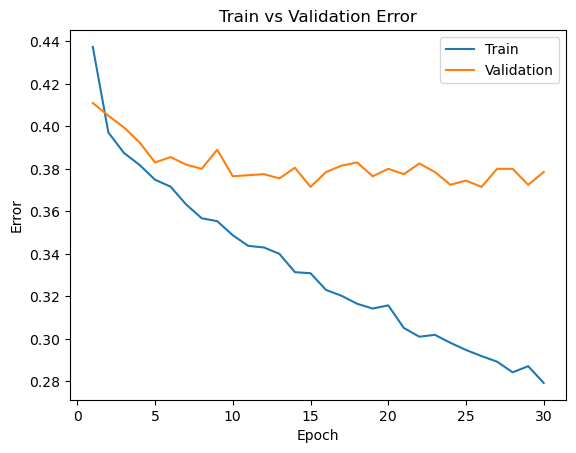

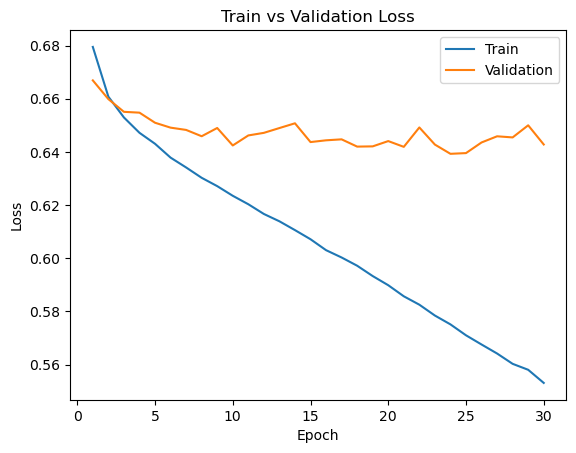

In [34]:
# train again with different hyperparameters. previous one was overfitting with learning rate 0.01
pigeon = Pigeon()
train_net(pigeon, batch_size=64, learning_rate=0.001, num_epochs=30)
model_path = get_model_name("pigeon", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.45475, Train loss: 0.6869791254164681 |Validation err: 0.4125, Validation loss: 0.6776074282824993
Epoch 2: Train err: 0.408625, Train loss: 0.6691889819644746 |Validation err: 0.406, Validation loss: 0.6666149497032166
Epoch 3: Train err: 0.39875, Train loss: 0.6617650474820819 |Validation err: 0.406, Validation loss: 0.662542250007391
Epoch 4: Train err: 0.394625, Train loss: 0.6566719696635291 |Validation err: 0.4015, Validation loss: 0.6587135009467602
Epoch 5: Train err: 0.38675, Train loss: 0.6528311031205314 |Validation err: 0.4045, Validation loss: 0.6568343415856361
Epoch 6: Train err: 0.383375, Train loss: 0.6499705343019395 |Validation err: 0.397, Validation loss: 0.655886285007
Epoch 7: Train err: 0.37925, Train loss: 0.6471262205214727 |Validation err: 0.396, Validation loss: 0.6538579389452934
Epoch 8: Train err: 0.3745, Train loss: 0.6444336876036629 |Validation err: 0.3915,

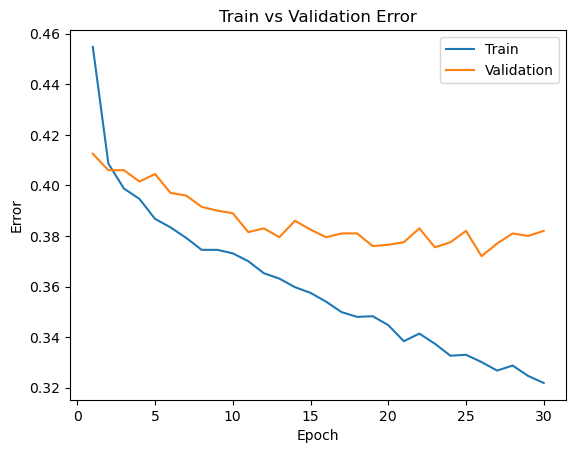

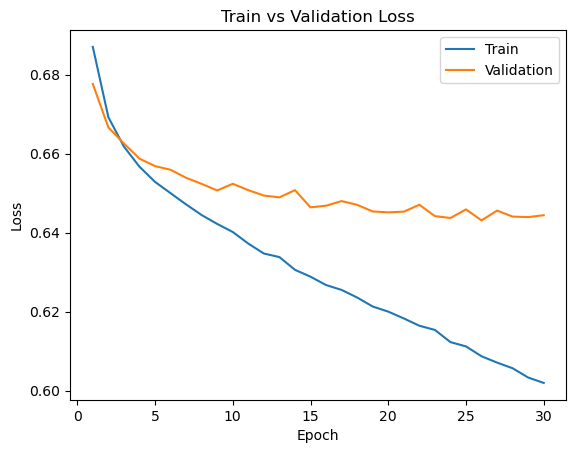

In [35]:
# train again with different hyperparameters. 
pigeon = Pigeon()
train_net(pigeon, batch_size=128, learning_rate=0.001, num_epochs=30)
model_path = get_model_name("pigeon", batch_size=128, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

In [36]:
pigeon = Pigeon()
model_path = get_model_name(pigeon.name, batch_size=128, learning_rate=0.001, epoch=26)
state = torch.load(model_path)
pigeon.load_state_dict(state)

_, _, test_loader, _ = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(pigeon, test_loader, criterion)
print(f"Test classification error for ANN: {test_err}, Test loss: {test_loss}")

Files already downloaded and verified
Files already downloaded and verified
Test classification error for ANN: 0.364, Test loss: 0.6400346793234348


**Answer**

The ANN test error is `0.364`. This is much higher than the CNN's test error at `0.3`. Therefore a CNN architecture is more suited for this problem as it has a higher accuracy compared to the ANN.